# Laboratorio 1

- Daniel Alfredo Rayo Roldan
- Gerardo Pineda Riveiro

## Repo:
https://github.com/DanielRasho/DS-Lab1.git

In [87]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro

## Cargado de datos

In [88]:
xls = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=None)

resultados = {}

for nombre_hoja, df in xls.items():
    hoja_df = pd.read_excel("./data/preciosLimpio.xlsx", sheet_name=nombre_hoja, header=7, usecols="A,C,D,E,F,G,H")
    resultados[nombre_hoja] = hoja_df

In [89]:
for nombre_hoja in resultados:
    df = resultados[nombre_hoja]
    resultados[nombre_hoja] = df.iloc[1:].reset_index(drop=True)

In [90]:
resultados["2024"]

,FECHA,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,2024-01-01,30.44,28.95,29.47,18.99,115,4.6
1,2024-01-02,30.44,28.95,29.47,18.99,115,4.6
2,2024-01-03,30.47,28.97,29.48,18.99,115,4.6
3,2024-01-04,30.47,28.97,29.48,18.99,115,4.6
4,2024-01-05,30.47,28.97,29.48,18.99,115,4.6
...,...,...,...,...,...,...,...
361,2024-12-27,28.99,27.49,25.51,17.94,110,4.4
362,2024-12-28,28.99,27.49,25.51,17.94,110,4.4
363,2024-12-29,28.99,27.49,25.51,17.94,110,4.4
364,2024-12-30,28.95,27.45,25.47,18.74,110,4.4


In [91]:
df_final = pd.DataFrame()

for nombre_hoja, df in resultados.items():
    df["Año"] = nombre_hoja
    df_final = pd.concat([df_final, df], ignore_index=True)

In [92]:
df_final.drop(columns=["Bunker"], inplace=True)
df_final.set_index("FECHA", inplace=True)
df_final.sort_index(ascending=True, inplace=True)

In [93]:
df_final.rename(columns={"Glp Cilindro 25Lbs." : "Gas 25Lbs", "Unnamed: 7": "Gas 1Lb"}, inplace=True)
df_final["Month"] = df_final.index.month
df_final["Año"] = df_final["Año"].astype(int)
df_final["Superior"] = df_final["Superior"].astype(float)
df_final["Regular"] = df_final["Regular"].astype(float)
df_final["Diesel"] = df_final["Diesel"].astype(float)
df_final["Gas 25Lbs"] = df_final["Gas 25Lbs"].astype(float)
df_final["Gas 1Lb"] = df_final["Gas 1Lb"].astype(float)
df_final

,Superior,Regular,Diesel,Gas 25Lbs,Gas 1Lb,Año,Month
FECHA,,,,,,,
2021-01-01,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-02,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-03,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-04,21.91,21.11,17.61,99.0,3.96,2021,1
2021-01-05,21.91,21.11,17.61,99.0,3.96,2021,1
...,...,...,...,...,...,...,...
2025-07-09,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-10,30.98,29.49,27.00,120.0,4.80,2025,7
2025-07-11,30.98,29.49,27.00,120.0,4.80,2025,7


## Exploración de Datos

**Se decidió estudiar los precios de la Gasolina Super, Diésel y Gas Licuado entre 2021 y 2025**. Una primera inspección de los datos nos indicó que el recurso más caro son los cilindros de 25 Lbs de gas licuado (precio promedio Q121.38) seguido de lejos por la gasolina superior ( Q32.15 ) y diésel (Q28.40). 

In [94]:
# Basic info
print(df_final.info())
print(df_final.describe())

# Check for missing values
print(df_final.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1655 entries, 2021-01-01 to 2025-07-13
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Superior   1655 non-null   float64
 1   Regular    1655 non-null   float64
 2   Diesel     1655 non-null   float64
 3   Gas 25Lbs  1655 non-null   float64
 4   Gas 1Lb    1655 non-null   float64
 5   Año        1655 non-null   int64  
 6   Month      1655 non-null   int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 97.0 KB
None
          Superior      Regular       Diesel    Gas 25Lbs      Gas 1Lb  \
count  1655.000000  1655.000000  1655.000000  1655.000000  1655.000000   
mean     32.149142    30.841692    28.407299   121.387680     4.855571   
std       3.816833     3.611342     4.870410     9.020728     0.360928   
min      21.910000    21.110000    17.610000    99.000000     3.960000   
25%      29.510000    28.280000    25.440000   115.000000     4.600000   
50%   

A continuación se ve la serie de tiempo de precios de los combustibles, todas las series empiezan desde el 1 de enero de 2021, hasta el 13 de junio de 2025, siendo un total 1655 registros (1 registro diario). De la gráfica se pueden obtener algunas conclusiones:
- Los precios varian en escala de semanas, es decir, un precio de combustible suele estar unos cuantos dias/semanas/meses antes de cambiar a un nuevo valor.
- Se observa ciertos patrones de estacionalidad entre finales de 2021 y principios de 2023.
- El gas licuado es de todos el que mantiene el mismo precio en largos periodos de tiempo.

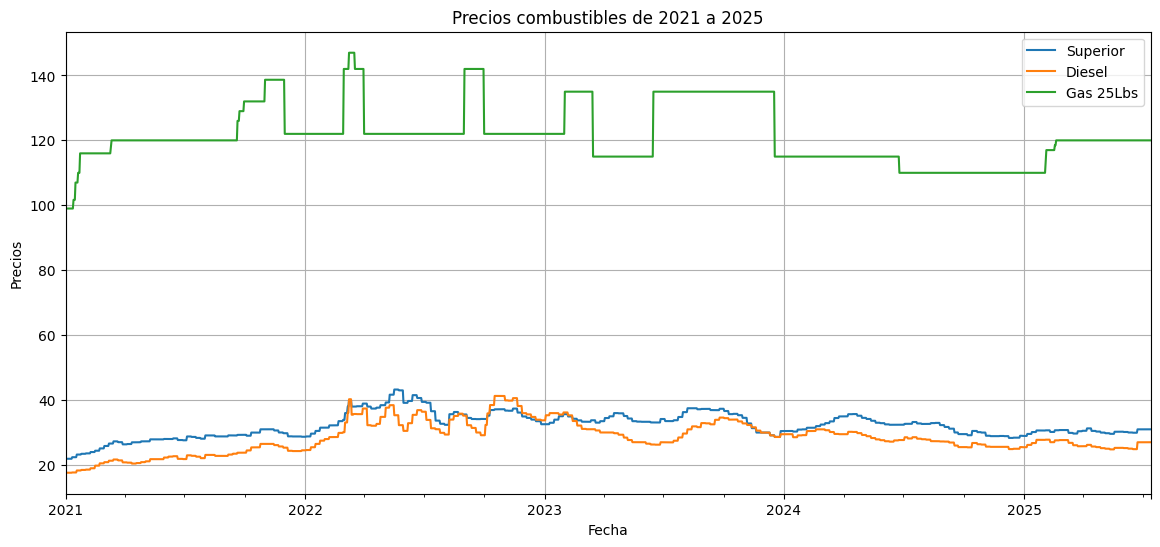

In [102]:
df_final.plot(figsize=(14, 6), y=['Superior', 'Diesel', 'Gas 25Lbs'], title="Precios combustibles de 2021 a 2025")
plt.ylabel("Precios")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

A continuación, también se condujo tests de normalidad sobre los precios de los combustibles, en ninguno de los casos se determinó que un combustible tuviera una distribución normal de precios, sino que era mucho más esporádico.

In [96]:
for col in ["Superior", "Diesel", "Gas 25Lbs"]:
    stat, p = shapiro(df_final[col].dropna())
    print(f"{col}: p = {p}")
    if p > 0.05:
        print("  -> Likely normal")
    else:
        print("  -> Not normal")

Superior: p = 3.9915074748457513e-10
  -> Not normal
Diesel: p = 4.887717605412204e-11
  -> Not normal
Gas 25Lbs: p = 3.252932875953924e-31
  -> Not normal


También se decidio estudiar los meses con precios promdio más alto a lo largo de los años, para descubrir si había alguna relación entre diferentes combustibles, sin embargo, a excepción de 2021 entre diesel y gasolina super, no hay coincidencia entre meses, es decir los incrementos en el precio de un combustible van de la mano con el aumento en el precio de los otros. La tabla a continuación resume los meses de mayor costo promedio para cada año y combustible:

In [98]:
monthly_avg = df_final.groupby(["Año", "Month"])[["Diesel", "Superior", "Gas 25Lbs"]].mean()
max_months = monthly_avg.groupby("Año").idxmax()
max_months

,Diesel,Superior,Gas 25Lbs
Año,,,
2021,"(2021, 11)","(2021, 11)","(2021, 11)"
2022,"(2022, 11)","(2022, 5)","(2022, 3)"
2023,"(2023, 1)","(2023, 8)","(2023, 2)"
2024,"(2024, 2)","(2024, 4)","(2024, 1)"
2025,"(2025, 2)","(2025, 7)","(2025, 3)"


Por último, en la misma linea de estudio sobre los picos en los precios, se calculo los 3 meses con mayores picos en cada año. Estas son las concluciones descubiertas:

- Diesel: De 2021 a 2022, tenia sus picos a finales de año, mientras que para el resto de años los picos ocurrian a principio de año.
- Gasolina: No hay una epoca del año común donde los precios aumenten, sin embargo los meses pico suelen ser cercanos.
- Gas licuado: La alza de precios suele ocurrir a principios de año.

In [99]:
top3_months_per_year = {}

for year, group in monthly_avg.groupby(level=0):  # level=0 is Year
    top_months = {}
    for fuel in ["Diesel", "Superior", "Gas 25Lbs"]:
        top_months[fuel] = group[fuel].nlargest(3)
    top3_months_per_year[year] = top_months

In [100]:
import calendar

for year, fuels in top3_months_per_year.items():
    print(f"\nYear {year}")
    for fuel, series in fuels.items():
        print(f"  {fuel}:")
        for (y, m), val in series.items():
            month_name = calendar.month_name[m]
            print(f"    {month_name} ({m}): {val:.2f}")


Year 2021
  Diesel:
    noviembre (11): 26.14
    octubre (10): 25.29
    diciembre (12): 24.50
  Superior:
    noviembre (11): 30.59
    octubre (10): 29.92
    septiembre (9): 29.11
  Gas 25Lbs:
    noviembre (11): 138.67
    octubre (10): 132.00
    septiembre (9): 123.10

Year 2022
  Diesel:
    noviembre (11): 39.29
    octubre (10): 38.29
    marzo (3): 35.69
  Superior:
    mayo (5): 41.45
    junio (6): 40.20
    abril (4): 37.98
  Gas 25Lbs:
    marzo (3): 143.45
    septiembre (9): 142.00
    enero (1): 122.00

Year 2023
  Diesel:
    enero (1): 35.62
    febrero (2): 33.93
    octubre (10): 33.89
  Superior:
    agosto (8): 37.15
    septiembre (9): 37.10
    octubre (10): 35.80
  Gas 25Lbs:
    febrero (2): 135.00
    julio (7): 135.00
    agosto (8): 135.00

Year 2024
  Diesel:
    febrero (2): 30.48
    marzo (3): 30.07
    abril (4): 29.87
  Superior:
    abril (4): 35.31
    marzo (3): 33.79
    mayo (5): 33.63
  Gas 25Lbs:
    enero (1): 115.00
    febrero (2): 115.00

### Precios de Gasolina

<Figure size 1000x500 with 0 Axes>

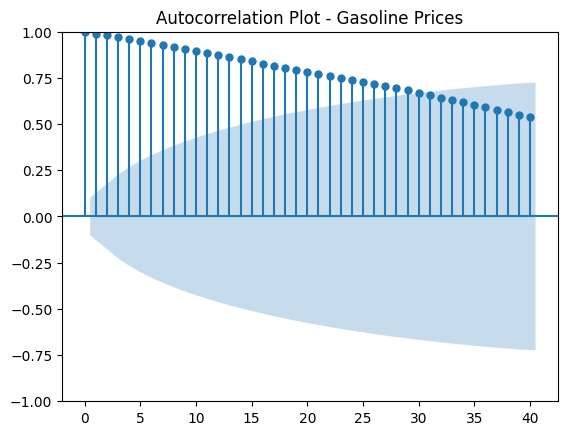

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

# Example: use 'gasoline' price series
plt.figure(figsize=(10, 5))
plot_acf(df['Diesel'], lags=40)
plt.title("Autocorrelation Plot - Gasoline Prices")
plt.show()

### Precios de Diesel

### Precios de Gas Licuado

## Series temporales

### Precios de Gasolina